In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import json
import time
import pytensor 
import pymc as pm
import arviz as az
import jax
import jax.numpy as jnp
import pyhf
import scipy.stats as sps
pyhf.set_backend('jax')

from jax import grad, jit, vmap, value_and_grad, random
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

# Building priors from auxiliary constraints

## Op

In [2]:
### Class that creates the model Op
class Op(pt.Op):
    itypes = [pt.dvector]  # Expects a vector of parameter values
    otypes = [pt.dvector]  # Outputs a vector of values (the model.expected_actualdata)

    def __init__(self, name, func):
        ## Add inputs as class attributes
        self.func = func
        self.name = name

    def perform(self, node, inputs, outputs):
        ## Method that is used when calling the Op
        (theta,) = inputs  # Contains my variables

        ## Calling input function (in our case the model.expected_actualdata)
        result = self.func(theta)

        ## Output values of model.expected_actualdata
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

## Model

In [41]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 3],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [55, 55, 55],
     'modifiers': [
        ## Lumi / Normal
        {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 7, 7]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 7, 7]},
        {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7, 7, 7]},
        ## Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [65, 65, 66], 'lo_data': [40, 40, 40]}},
        {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [66, 65, 60], 'lo_data': [40, 40, 39]}},
        ## Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [2.0, 2.0, 2.4],}
         ]},    
                                 
    ]},
    ],
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }
        ],}
)

nBins = len(model.expected_actualdata(model.config.suggested_init()))

### Observations
obs = model.expected_actualdata(model.config.suggested_init())

In [35]:
### Choose the right .json file
n = "DisplacedLeptons"

if n == "ttbar":
    with open("ttbar_ljets_xsec_inclusive_pruned.json") as serialized:
        spec = json.load(serialized)
    nBins = 37

if n == "DisplacedLeptons":
    with open("/Users/malinhorstmann/Documents/pyhf_pymc/PPC/SRee_SRmm_Srem.json") as serialized:
        spec = json.load(serialized)
    nBins = 3



### Create pyhf model from it
workspace = pyhf.Workspace(spec)

model = workspace.model()

### Observations
obs = workspace.data(model, include_auxdata=False)

## DisplacedLeptons / ttbar

Note: 
- I stitch to `model.confif.par_map`



### Inference

In [14]:
### Applying the Op with arguments (function, name)
mainOp = Op("mainOp", jax.jit(model.expected_actualdata))

### Opening the PyMC model space
with pm.Model() as basic_model:

    ## Stitching
    unconstr_idx = np.concatenate([
        np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.unconstrained)
    ])
    norm_idx = np.concatenate([
        np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal)
    ])
    
    target = np.array(np.concatenate([unconstr_idx, norm_idx]))

    ## Parameters
        # Unconstrained
    unconstr_pars = []
    unconstr_pars.extend(pm.Normal(f'{model.config.poi_name}', mu=[1], sigma=[1]))

        # Normal (histosys, lumi, staterror)
    norm_pars = []
    mu = []
    sigma = []
    for k,v in model.config.par_map.items():
        if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal):
            for i in model.constraint_model.viewer_aux.selected_viewer._partition_indices[model.config.auxdata_order.index(k)]:
                mu.append(model.config.auxdata[int(i)])
                sigma.append(model.constraint_model.constraints_gaussian.sigmas[int(i)])
    norm_pars.extend(pm.Normal('Normals', mu=mu, sigma=sigma))

    # pars = np.concatenate([unconstr_pars, norm_pars])
    pars = np.concatenate([unconstr_pars, norm_pars])
    final = pt.as_tensor_variable(pars[target.argsort()].tolist())
    
    ## Model for the model.expected_actualdata()
        # Attention: pm.Poisson breaks down, as \lambda < 0 occasionally if mu=0.0
    main = pm.Normal("main", mu=mainOp(final), observed=obs)

    ## Sampling
    post_data = pm.sample(500)
    prior_data = pm.sample_prior_predictive(500)
    post_pred = pm.sample_posterior_predictive(post_data)

Plotting data and the prior and posterior predictives ..

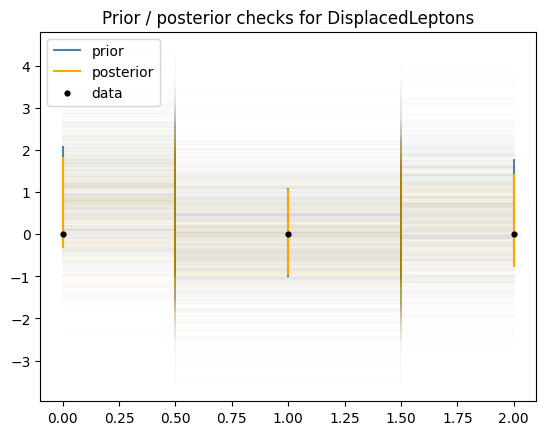

In [15]:
### Plotting ...

    ## Prior predictive
plt.step(np.linspace(0,nBins-1,nBins),prior_data.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_data.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label="prior");

    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label="posterior")

    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Prior / posterior checks for {n}')

plt.savefig(f'PPC_{n}.pdf')
plt.show()

### Checking the stitching order

In [22]:
### I stitch to model.config.par_map
model.config.par_order

['lumi',
 'mu_Sig',
 'ucbSRee',
 'SigXSec',
 'cuts_SRee_LRT',
 'cuts_SRee_LRTfilter',
 'ucsSRee_Slep_1000_10',
 'ucsSRee_disp',
 'ucsSRee_pileupWeight',
 'ucbSRem',
 'ucbSRmm',
 'cuts_SRmm_LRT',
 'cuts_SRmm_LRTfilter',
 'ucsSRmm_Slep_1000_10',
 'ucsSRmm_disp',
 'ucsSRmm_mu_sel',
 'ucsSRmm_mu_trig',
 'ucsSRmm_pileupWeight']

In [36]:
### Extracting the input values from the auxiliary data
    ## Stitching
unconstr_idx = np.concatenate([
    np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.unconstrained)
])
norm_idx = np.concatenate([
    np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal)
])
target = np.array(np.concatenate([unconstr_idx, norm_idx]))

    ## Unconstrained
poiMu = [1]
poiSigma = [0]

    ## Normals
mu = []
sigma = []
for k,v in model.config.par_map.items():
    if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal):
        for i in model.constraint_model.viewer_aux.selected_viewer._partition_indices[model.config.auxdata_order.index(k)]:
            mu.append(model.config.auxdata[int(i)])
            sigma.append(model.constraint_model.constraints_gaussian.sigmas[int(i)])

### Stitching the input vectors
muN = np.concatenate([mu])[norm_idx.argsort()].tolist()
sigmaN = np.concatenate([sigma])[norm_idx.argsort()].tolist()

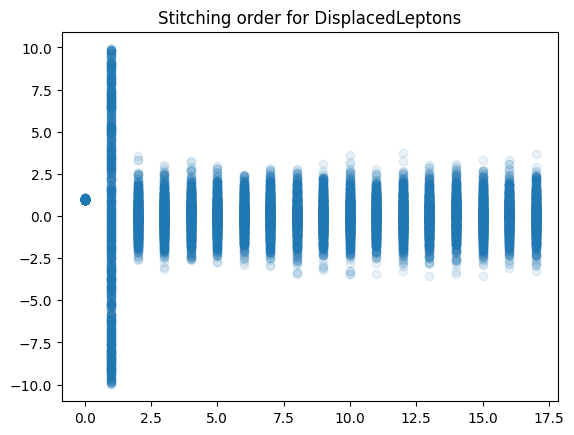

In [37]:
### Building the pdfs
sampledPOI = sps.uniform(-10, 20).rvs((1000, 1))
sampledN = sps.norm(muN, sigmaN).rvs((1000, len(muN)))

all = np.concatenate([sampledPOI, sampledN], axis=-1)
final = all[..., target.argsort()]

par_position = np.tile(np.arange(1+len(muN)).reshape(1,-1), (1000, 1))

### Plotting
plt.scatter(par_position, final, alpha = 0.1)

plt.title(f'Stitching order for {n}')
plt.savefig(f'Stitching_order_{n}.pdf')

plt.show()

## Dummy Model

### Inference

In [44]:
### Applying the Op with arguments (function, name)
mainOp = Op("mainOp", jax.jit(model.expected_actualdata))

### Opening the PyMC model space
with pm.Model() as basic_model:

    ## Stitching
    unconstr_idx = np.concatenate([
        np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.unconstrained)
    ])
    norm_idx = np.concatenate([
        np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal)
    ])
    poiss_idx = np.concatenate([
        np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.constrained_by_poisson)
    ])
    
    target = np.array(np.concatenate([unconstr_idx, norm_idx, poiss_idx]))

    ## Parameters
        # Unconstrained
    unconstr_pars = []
    unconstr_pars.extend(pm.Normal(f'{model.config.poi_name}', mu=[1], sigma=[1]))

        # Normal (histosys, lumi, staterror)
    norm_pars = []
    mu = []
    sigma = []
    for k,v in model.config.par_map.items():
        if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal):
            for i in model.constraint_model.viewer_aux.selected_viewer._partition_indices[model.config.auxdata_order.index(k)]:
                mu.append(model.config.auxdata[int(i)])
                sigma.append(model.constraint_model.constraints_gaussian.sigmas[int(i)])
    norm_pars.extend(pm.Normal('Normals', mu=mu, sigma=sigma))

        # Poisson (shapesys)
        # How to choose alpha and beta is still unclear to me
        # Choosing them in a way that the Gamma is centered around zero gives pretty results
    poiss_pars = []
    alpha = []
    beta = []
    for k,v in model.config.par_map.items():
        if isinstance(v['paramset'], pyhf.parameters.constrained_by_poisson):
            for i in model.constraint_model.viewer_aux.selected_viewer._partition_indices[model.config.auxdata_order.index(k)]:
                alpha.append(model.config.auxdata[int(i)] + 10000)
                beta.append(model.config.auxdata[int(i)] + 10000)
    poiss_pars.extend(pm.Gamma('Gammas', alpha=alpha, beta=beta))

    pars = np.concatenate([unconstr_pars, norm_pars, poiss_pars])
    final = pt.as_tensor_variable(pars[target.argsort()].tolist())
    
    ## Model for the model.expected_actualdata()
        # Attention: pm.Poisson breaks down, as \lambda < 0 occasionally if mu=0.0
    main = pm.Normal("main", mu=mainOp(final), observed=obs)

    ## Sampling
    post_data = pm.sample(500)
    prior_data = pm.sample_prior_predictive(500)
    post_pred = pm.sample_posterior_predictive(post_data)

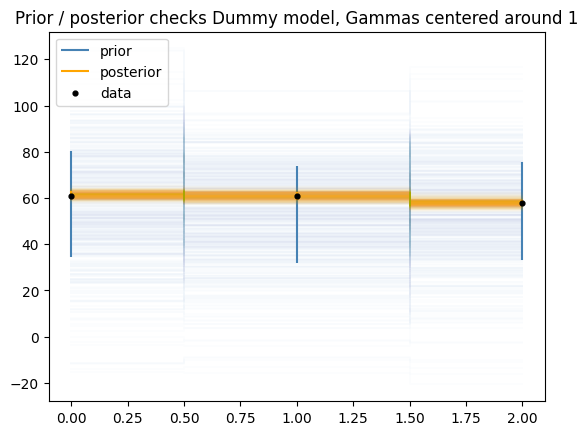

In [45]:
### Plotting ...

    ## Prior predictive
plt.step(np.linspace(0,nBins-1,nBins),prior_data.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_data.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label="prior");

    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label="posterior")

    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Prior / posterior checks Dummy model, Gammas centered around 1')

plt.savefig(f'PPC_Dummy.pdf')

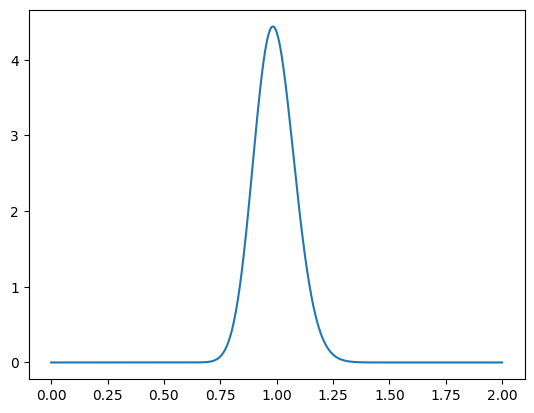

In [53]:
### Checking form of the gamma priors
xi = np.linspace(0, 2, 1000)
sigma = 5/55
    ## a = sigma**(-2)
auxdata = (1/sigma)**2
alpha = auxdata
beta = auxdata + 1
    ## Attention, notation is weird but the alpha and beta here are the same ones from pm.gamma
pi = sps.gamma(alpha, scale = 1/beta).pdf(xi)

###
plt.plot(xi, pi)
plt.show()

### Checking the stitching order

In [33]:
### I stitch to model.config.par_map
model.config.par_order

['corr_bkg',
 'corr_bkg1',
 'corr_bkg2',
 'lumi',
 'mu',
 'uncorr_bkg',
 'uncorr_bkg1',
 'uncorr_bkg2',
 'my_staterror']

In [75]:
### Extracting the input values from the auxiliary data
    ## Stitching
unconstr_idx = np.concatenate([
    np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.unconstrained)
])
norm_idx = np.concatenate([
    np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal)
])
poiss_idx = np.concatenate([
    np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.constrained_by_poisson)
])

# target = np.array(np.concatenate([unconstr_idx, norm_idx]))
target = np.array(np.concatenate([unconstr_idx, norm_idx, poiss_idx]))

    ## Unconstrained
poiMu = [1]
poiSigma = [0]

    ## Normals
mu = []
sigma = []
for k,v in model.config.par_map.items():
    if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal):
        for i in model.constraint_model.viewer_aux.selected_viewer._partition_indices[model.config.auxdata_order.index(k)]:
            mu.append(model.config.auxdata[int(i)])
            sigma.append(model.constraint_model.constraints_gaussian.sigmas[int(i)])

    ## Poisson 
alpha = []
beta = []
for k,v in model.config.par_map.items():
    if isinstance(v['paramset'], pyhf.parameters.constrained_by_poisson):
        for i in model.constraint_model.viewer_aux.selected_viewer._partition_indices[model.config.auxdata_order.index(k)]:
            alpha.append(model.config.auxdata[int(i)])
            beta.append(1 / model.config.auxdata[int(i)])

### Stitching the input vectors
muN = np.concatenate([mu])[norm_idx.argsort()].tolist()
sigmaN = np.concatenate([sigma])[norm_idx.argsort()].tolist()

alphaP = np.concatenate([alpha])[poiss_idx.argsort()].tolist()
betaP = np.concatenate([beta])[poiss_idx.argsort()].tolist()

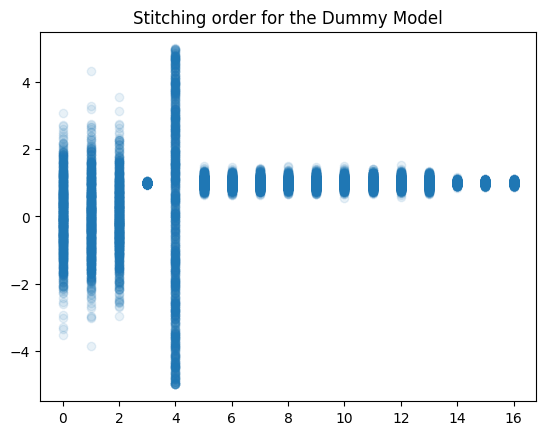

In [77]:
### Building the pdfs
sampledPOI = sps.uniform(-5, 10).rvs((1000, 1))
sampledN = sps.norm(muN, sigmaN).rvs((1000, len(muN)))
sampledP = sps.gamma(alphaP, scale = betaP).rvs((1000, len(alphaP)))

all = np.concatenate([sampledPOI, sampledN, sampledP], axis=-1)
# all = np.concatenate([sampledPOI, sampledN], axis=-1)
final = all[..., target.argsort()]

par_position = np.tile(np.arange(1+len(muN)+len(alphaP)).reshape(1,-1), (1000, 1))
# par_position = np.tile(np.arange(1+len(muN)).reshape(1,-1), (1000, 1))

### Plotting
plt.scatter(par_position, final, alpha = 0.1)

plt.title(f'Stitching order for the Dummy Model')
plt.savefig(f'Stitching_order_Dummy.pdf')

plt.show()